# Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

# Prepare the Dataset

In [2]:
def map_image(image,label):
  image = tf.cast(image,tf.float32)
  image = image / 255.0

  return image,image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load("fashion_mnist",
                          as_supervised = True,
                          split = 'train')
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist',
                         as_supervised = True,
                         split = 'test')
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.6K82UM_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.6K82UM_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


# Define the Model


<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" height = "75%"/>

In [4]:
def encoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(
      filters = 64,
      kernel_size = (3,3),
      activation = 'relu',
      padding = 'same'
  )(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(
      pool_size = (2,2)
  )(conv_1)

  conv_2 = tf.keras.layers.Conv2D(
      filters = 128,
      kernel_size = (3,3),
      activation = 'relu',
      padding = 'same'
  )(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(
      pool_size = (2,2)
  )(conv_2)

  return max_pool_2

In [5]:
def bottle_neck(inputs):
  bottle_neck = tf.keras.layers.Conv2D(
      filters = 256,
      kernel_size = (3,3),
      activation = 'relu',
      padding = 'same'
  )(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      activation = 'sigmoid',
      padding = 'same'
  )(bottle_neck)

  return bottle_neck,encoder_visualization

In [14]:
def decoder(inputs):
  conv_1 = tf.keras.layers.Conv2D(
      filters = 128,
      kernel_size = (3,3),
      activation = 'relu',
      padding = 'same',
  )(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(
      size = (2,2),
  )(conv_1)

  conv_2 = tf.keras.layers.Conv2D(
      filters = 64,
      kernel_size = (3,3),
      activation = 'relu',
      padding = 'same'
  )(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(
      size = (2,2)
  )(conv_2)

  conv_3 = tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      activation = 'sigmoid',
      padding = 'same'
  )(up_sample_2)

  return conv_3

In [15]:
def convolutional_auto_encoder():
  inputs = tf.keras.layers.Input(shape = (28,28,1,))
  encoder_output = encoder(inputs)
  bottleneck_output,encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = tf.keras.Model(inputs = inputs,outputs = decoder_output)
  encoder_model = tf.keras.Model(inputs = inputs,outputs = encoder_visualization)

  return model,encoder_model

In [16]:
convolutional_model,convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 256)         2951

# Compile and Train the Model

In [17]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = 'binary_crossentropy'
)

conv_model_history = convolutional_model.fit(
    train_dataset,
    steps_per_epoch = train_steps,
    validation_data = test_dataset,
    validation_steps = valid_steps,
    epochs = 40
)

Epoch 1/40
468/468 [==============================] - 13s 24ms/step - loss: 0.2870 - val_loss: 0.2654
Epoch 2/40
468/468 [==============================] - 11s 24ms/step - loss: 0.2602 - val_loss: 0.2596
Epoch 3/40
468/468 [==============================] - 11s 23ms/step - loss: 0.2556 - val_loss: 0.2565
Epoch 4/40
468/468 [==============================] - 11s 25ms/step - loss: 0.2534 - val_loss: 0.2541
Epoch 5/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2516 - val_loss: 0.2530
Epoch 6/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2506 - val_loss: 0.2520
Epoch 7/40
468/468 [==============================] - 13s 27ms/step - loss: 0.2497 - val_loss: 0.2512
Epoch 8/40
468/468 [==============================] - 11s 23ms/step - loss: 0.2490 - val_loss: 0.2506
Epoch 9/40
468/468 [==============================] - 10s 22ms/step - loss: 0.2485 - val_loss: 0.2508
Epoch 10/40
468/468 [==============================] - 11s 24ms/step - loss: 0.248

# Display Sample Results

In [21]:
def display_one_row(disp_images,offset,shape = (28,28)):
  for idx,test_image in enumerate(disp_images):
    plt.subplot(3,10,offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image,shape)
    plt.imshow(test_image,cmap = 'gray')

def display_results(disp_input_images,disp_encoded,disp_predicted,enc_shape = (8,4)):
  plt.figure(figsize = (15,5))
  display_one_row(disp_input_images,0,shape = (28,28,))
  display_one_row(disp_encoded,10,shape = enc_shape)
  display_one_row(disp_predicted,20,shape = (28,28,))

1/1 [==============================] - 0s 90ms/step


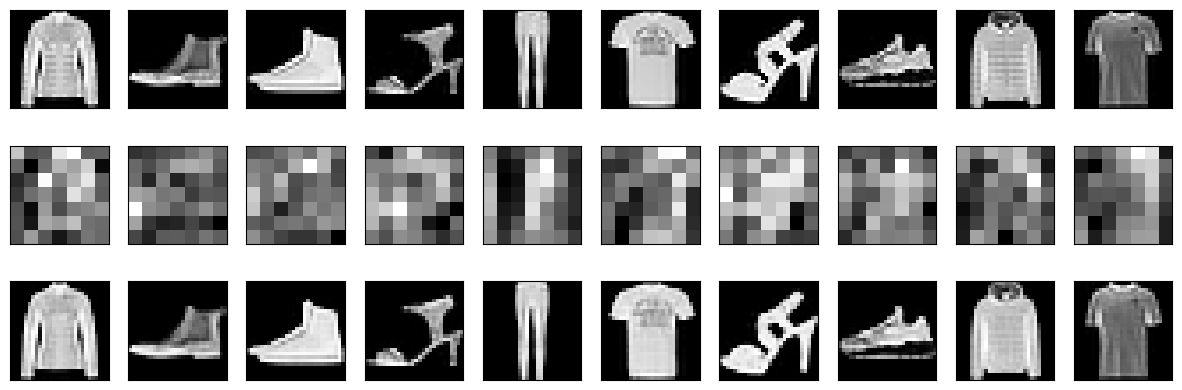

In [22]:
# Take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# Take the input images and put them in a list
output_samples = []
for input_image,image in tfds.as_numpy(test_dataset):
  output_samples = input_image

# Pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples,(10,28,28,1))

# Get the encoder output
encoded = convolutional_encoder_model.predict(conv_output_samples)

# Get a prediction for some values in the dataset'
predicted = convolutional_model.predict(conv_output_samples)

# Display the samples, encodings and decoded values
display_results(conv_output_samples,encoded,predicted,enc_shape = (7,7))